# **Laboratorio 2:** MLFlow

MLFLow es una plataforma de código abierto para administrar el ciclo de vida de ML, incluida la experimentación, la reproducibilidad, la implementación y un registro de modelo central. Actualmente, MLFLow ofrece cuatro componentes:


<img src="https://images.datacamp.com/image/upload/v1666023613/M_Lflow_Components_64d5714287.png" width="70%">

<img src="https://www.databricks.com/sites/default/files/2020/04/databricks-adds-access-control-to-mlflow-model-registry_01.jpg" width="70%">


Ref. https://www.datacamp.com/tutorial/mlflow-streamline-machine-learning-workflow

## 1. Crear un entorno Conda

Ejecutar los siguientes comandos en la terminal. Se sugiere asegurarse de que conda esté instalado:

1. `conda create -n mlops python=3.9 ipykernel`
creará un env conda llamado mlops e instalará la versión 3.9 de python y un ipykernel dentro de este entorno

2. Activar el ambiente
`conda activate mlops`

3. Agregar el entorno recién creado al notebook como kernel
`python -m ipykernel install --user --name=mlops`

4. Instalar los notebooks de jupyter dentro del entorno
`pip install notebook`

5. Instalar todas las dependencias requeridas para ejecutar el presente notebook

* `pip install pandas`
* `pip install numpy`
* `pip install scikit-learn`
* `pip install imblearn`
* `pip install matplotlib`
* `pip install mlflow`

Finalmente, abrir este notebook usando el siguiente comando: (desde el prompt de anaconda dentro del entorno de conda)

`jupyter notebook`


Se sugiere asegurarse que versión de Python esta usado, desde el notebook actual.

In [1]:
import sys
print(sys.executable)

/opt/anaconda3/envs/mlops3/bin/python


In [2]:
!python --version

Python 3.9.23


## 2. Machine Learning

En la siguiente sección se crearan funciones para todos los pasos involucrados en el ciclo de vida completo de entrenamiento del modelo.

In [3]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV

import mlflow

In [4]:
def load_data(path):
    data = pd.read_csv(path)
    return data

Descargar el dataset desde la siguiente dirección:
https://drive.google.com/file/d/19N0zrbRLKowXbXndALDGC1jaMCYiTFrn/view?usp=sharing
y ubicarlo al lado del presente notebook.

In [5]:
data = load_data('datasets/banking/banking.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [6]:
print("Número total de registros:", len(data))
print("Conteo de suscripciones confirmadas:", len(data.loc[data['y']==1]))
print("Conteo de no suscripciones:", len(data.loc[data['y']==0]))

Número total de registros: 41188
Conteo de suscripciones confirmadas: 4640
Conteo de no suscripciones: 36548


In [7]:
def data_cleaning(data):
    print("Valores nan en los datos:", data.isna().sum())
    data = data.dropna()
    print("Valores nan después de eliminar filas con datos vacios", data.isna().sum())

    return data

def preprocessing(data):

    data['education'] = np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] =='basic.4y', 'Basic', data['education'])

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

    for var in cat_vars:

        cat_list = 'var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1 = data.join(cat_list)
        data = data1

    cat_vars = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars = data.columns.values.tolist()
    to_keep = [i for i in data_vars if i not in cat_vars]

    final_data = data[to_keep]


    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')

    return final_data

def data_train_test_split(final_data):
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

def over_sampling_target_class(X_train, y_train):
    # Over-sampling usando SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

    # Verificar las nuevas cantidades de datos
    print("Nuevo número de instancias: ",len(os_data_X))
    print("Nuevo número de instancias sin suscripción:",len(os_data_y[os_data_y['y']==0]))
    print("Nuevo número de suscripciones",len(os_data_y[os_data_y['y']==1]))
    print("La nueva proporción de clientes sin suscripción:",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("La nueva proporción de clientes con suscripción:",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

    X_train = os_data_X
    y_train = os_data_y['y']

    return X_train, y_train

def training_basic_classifier(X_train,y_train):
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    return model

def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

def get_metrics(y_true, y_pred, y_pred_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

def create_roc_auc_plot(y_test, y_pred):
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.savefig('roc_auc_curve.png')

def create_confusion_matrix_plot(y_test, y_pred, labels):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels)
    plt.savefig('confusion_matrix.png')

Ajuste de Hiperparametros

In [8]:
def hyper_parameter_tuning(X_train, y_train):
    # Definir los rangos de los parámetros con el fin de pasarle la tarea de optimización a RandomizedSearchCV
    n_estimators = [5,21,51,101] # Número de árboles en el bosque aleatorio
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # Número máximo de niveles permitidos en cada árbol de decisión
    min_samples_split = [2, 6, 10] # Número mínimo de muestra para dividir un nodo
    min_samples_leaf = [1, 3, 4] # Número mínimo de muestra que se puede almacenar en un nodo hoja
    bootstrap = [True, False] # Método utilizado para muestrear puntos de datos

    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}

    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')

    # Imprimir los mejores parametros
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_

    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']

    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf,
                                         max_depth= max_depth, bootstrap=bootstrap)
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

Implementar ML para la clasificación de clientes con probabilidad de suscribirse al servicio ofrecido por el banco, tomando en cuenta sus características y las características de clientes anteriores desde el dataset `banking.csv`.

In [9]:
# Preprocesamiento y entrenamiento
def preprocess_train(dataset):
    data = load_data(dataset)
    cleaned_data = data_cleaning(data)
    final_data = preprocessing(cleaned_data)
    X_train, X_test, y_train, y_test = data_train_test_split(final_data)
    X_train, y_train = over_sampling_target_class(X_train, y_train)
    model = training_basic_classifier(X_train,y_train)

    return model, X_train, X_test, y_train, y_test

model, X_train, X_test, y_train, y_test = preprocess_train('datasets/banking/banking.csv')

Valores nan en los datos: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Valores nan después de eliminar filas con datos vacios age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Nuevo número de instancias:  51166
Nuevo número de in

/opt/anaconda3/envs/mlops3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Predicciones con el subconjunto de evaluación:
[0 0 0 ... 0 0 0]
Dist. de probabilidades de predicción con el subconjunto de evaluación:
[[0.97029703 0.02970297]
 [0.99009901 0.00990099]
 [0.96039604 0.03960396]
 ...
 [1.         0.        ]
 [0.66336634 0.33663366]
 [0.99009901 0.00990099]]
Métricas del modelo:


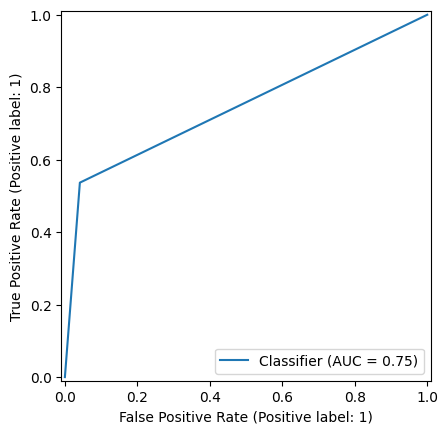

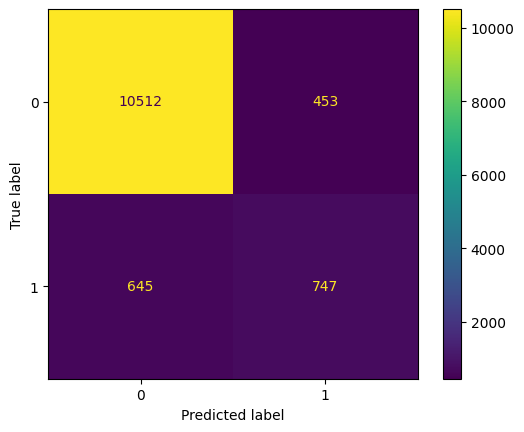

In [10]:
# Inferencia y evaluación
def predict_evaluate(model, X_test, y_test):
  print("Predicciones con el subconjunto de evaluación:")
  y_pred = predict_on_test_data(model, X_test)
  print(y_pred)
  print("Dist. de probabilidades de predicción con el subconjunto de evaluación:")
  y_pred_prob = predict_prob_on_test_data(model, X_test) #model.predict_proba(X_test)
  print(y_pred_prob)
  print("Métricas del modelo:")
  run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
  create_roc_auc_plot(y_test, y_pred)
  create_confusion_matrix_plot(y_test, y_pred, model.classes_)

  return run_metrics

run_metrics = predict_evaluate(model, X_test, y_test)

## 3. MLFlow

En la siguiente sección se registraran los experimentos, modelos, parametros y metricas con el módulo `tracking` de mlflow.

In [11]:
# Función para crear un experimento en MLFlow y registrar parámetros, métricas y archivos de artefactos como imágenes, etc.
def create_experiment(experiment_name, run_name, run_metrics, model, confusion_matrix_path = None,
                      roc_auc_plot_path = None, run_params = None):

    # mlflow.set_tracking_uri("http://localhost:8080") # Descomentar esta línea si desea usar cualquier base de datos como sqlite como almacenamiento de back-end
    mlflow.set_experiment(experiment_name)

    # start an execution by experiment
    with mlflow.start_run(run_name=run_name):

        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])

        mlflow.sklearn.log_model(model, "model")

        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')

        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")

        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})

    print('La ejecución: %s fue registrada en el experimento: %s' %(run_name, experiment_name))

Primer experimento con el modelo (básico) de `RandomForest`.  

Valores nan en los datos: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Valores nan después de eliminar filas con datos vacios age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Nuevo número de instancias:  51166
Nuevo número de in

/opt/anaconda3/envs/mlops3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Predicciones con el subconjunto de evaluación:
[0 0 0 ... 0 0 0]
Dist. de probabilidades de predicción con el subconjunto de evaluación:
[[0.99009901 0.00990099]
 [0.97029703 0.02970297]
 [0.96039604 0.03960396]
 ...
 [1.         0.        ]
 [0.63366337 0.36633663]
 [1.         0.        ]]
Métricas del modelo:


2025/08/25 15:04:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.54, 'entropy': 0.21}


2025/08/25 15:04:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


La ejecución: smote_aplicado_second fue registrada en el experimento: clasificador_basico


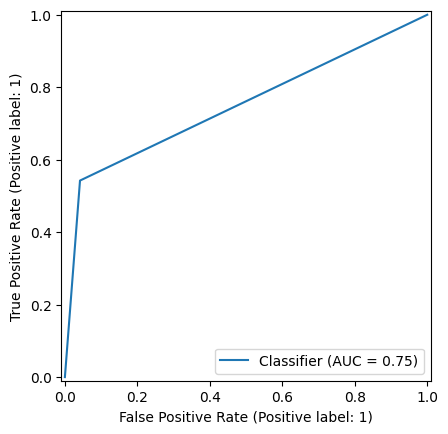

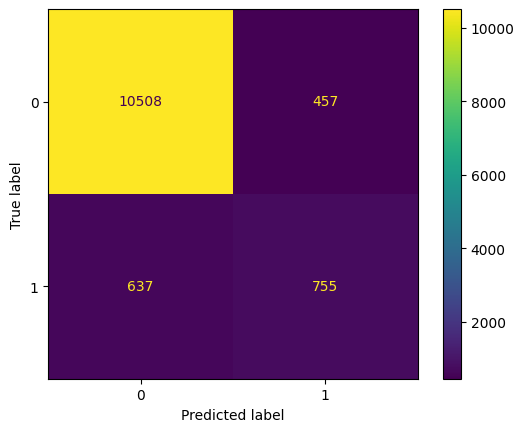

In [12]:
experiment_name = "clasificador_basico"
run_name = "smote_aplicado_second"

model, X_train, X_test, y_train, y_test = preprocess_train('datasets/banking/banking.csv')
run_metrics = predict_evaluate(model, X_test, y_test)
print(run_metrics)

create_experiment(experiment_name, # Nombre del experimento
                  run_name, # Nombre de la ejecución
                  run_metrics, # Métricas obtenidas
                  model, # Modelo ajustado
                  'confusion_matrix.png', # Ruta a la imagen de la mátriz de confusión
                  'roc_auc_curve.png', # Ruta a la imagen de la gráfica AUC
                  run_params = {"n_estimators":101} # Parametros utilizados al entrenar el modelo
                 )

Crear otro experimento después de ajustar los hiperparámetros y registrar el mejor conjunto de parámetros encontrados con la función `hyper_parameter_tuning`.

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 21, 51, 101], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 51, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 80, 'bootstrap': True}  

n_estimators 51
min_samples_split 2
min_samples_leaf 4
max_depth 80
bootstrap True
Predicciones con el subconjunto de evaluación:
[0 0 0 ... 0 0 0]
Dist. de probabilidades de predicción con el subconjunto de evaluación:
[[0.99009901 0.00990099]
 [0.97029703 0.02970297]
 [0.96039604 0.03960396]
 ...
 [1.         0.        ]
 [0.63366337 0.36633663]
 [1.         0.        ]]
Métricas del modelo:


2025/08/25 15:05:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.54, 'entropy': 0.21}


2025/08/25 15:05:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


La ejecución: modelo_tuneado_con_randomsearchcv fue registrada en el experimento: modelo_optimizado


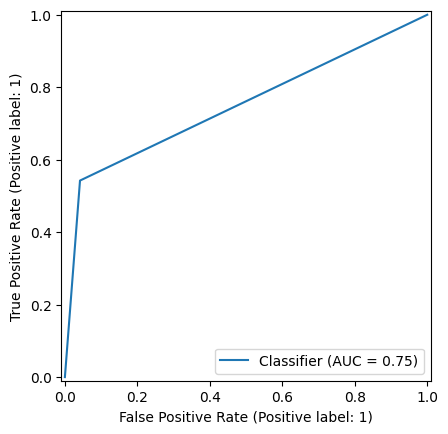

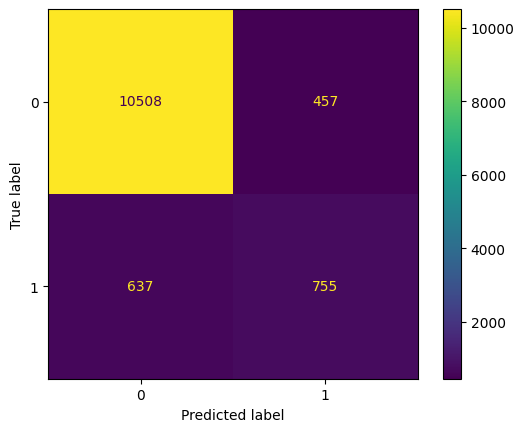

[CV] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, min_samples_leaf=4, min_samples_split=2, n_estimators=21; total time=   0.7s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=21; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=51; total time=   2.5s
[CV] END bootstrap=True, max_depth=120, min_samples_leaf=1, min_samples_split=6, n_estimators=21; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_samples_split=6, n_estimators=51; total time=   1.7s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=3, min_sa

In [13]:
experiment_name = "modelo_optimizado"
run_name="modelo_tuneado_con_randomsearchcv"

model_tuned, best_params = hyper_parameter_tuning(X_train, y_train)

# Mostrar mejores párametros
for param in best_params:
    print(param, best_params[param])

run_metrics = predict_evaluate(model, X_test, y_test)
print(run_metrics)

create_experiment(experiment_name, # Nombre del experimento
                  run_name, # Nombre de la ejecución
                  run_metrics, # Métricas obtenidas
                  model_tuned, # Modelo ajustado
                  'confusion_matrix.png', # Ruta a la imagen de la mátriz de confusión
                  'roc_auc_curve.png', # Ruta a la imagen de la gráfica AUC
                  run_params = best_params # Parametros encontrados con Random Search CV
                 )

## 4. Model Registry

Si se desea utilizar la función Model Registry, necesitamos una base de datos que apoye el registro. Las opciones de base de datos son `oracle`, `mysql`, `postgresql`, `sqlite`. En esta sección veremos la configuración para `mysql` y `sqlite`, siendo esta última la mas facil de configurar.

#### Usando MySQL

1. Crear una base de datos nueva para MLflow.

`CREATE DATABASE mlflow_tracking_database;`

2. Inicilizar el servidor de tracking de MLflow utilizando la base de datos MySQL.
` mlflow server \
   --backend-store-uri  mysql+pymysql://root@localhost/mlflow_tracking_database \
   --default-artifact-root  file:/./mlruns \
   -h 0.0.0.0 -p 8080`


3. Establecer el URI de seguimiento de MLflow (dentro de la sección de código).

  mlflow.set_tracking_uri("http://localhost:8080")

#### Usando SQLite

1. Inicilizar el servidor de tracking de MLflow utilizando una base de datos SQLite.

`mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 8080`


2. Establecer el URI de seguimiento de MLflow (dentro de la sección de código).
    
    mlflow.set_tracking_uri("http://localhost:8080")

Ref. https://www.mlflow.org/docs/latest/model-registry.html#model-registry-workflows

### 4.1 Agregar modelos a Model Registry: Método 1

Ref.: https://www.mlflow.org/docs/latest/model-registry.html

Hay tres formas para agregar un modelo al Model Registry con código. Primero, puede usar el método mlflow.`<model>.log_model()`. La siguiente función aplica esta estrategía:

In [15]:
# Set backend instead of store everything in files
mlflow.set_tracking_uri("http://localhost:8080")

Valores nan en los datos: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Valores nan después de eliminar filas con datos vacios age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Nuevo número de instancias:  51166
Nuevo número de in

/opt/anaconda3/envs/mlops3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Predicciones con el subconjunto de evaluación:
[0 0 0 ... 0 0 0]
Dist. de probabilidades de predicción con el subconjunto de evaluación:
[[0.99009901 0.00990099]
 [0.99009901 0.00990099]
 [0.95049505 0.04950495]
 ...
 [1.         0.        ]
 [0.72277228 0.27722772]
 [0.99009901 0.00990099]]
Métricas del modelo:


2025/08/25 15:35:55 INFO mlflow.tracking.fluent: Experiment with name 'clasificador_basico_model_registry' does not exist. Creating a new experiment.


{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.55, 'entropy': 0.2}


2025/08/25 15:35:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/25 15:35:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'randomforest-classifier'.
2025/08/25 15:35:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: randomforest-classifier, version 1


🏃 View run smote_aplicado at: http://localhost:8080/#/experiments/1/runs/eec64e756e3b4f64a06f2f1b6a80ad2d
🧪 View experiment at: http://localhost:8080/#/experiments/1


Created version '1' of model 'randomforest-classifier'.


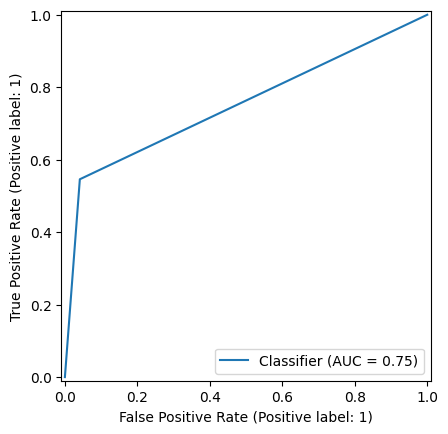

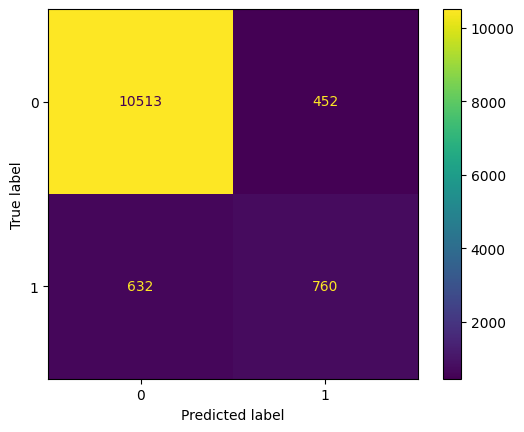

[CV] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.4s
[CV] END bootstrap=True, max_depth=120, min_samples_leaf=4, min_samples_split=2, n_estimators=21; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=21; total time=   0.8s
[CV] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=51; total time=   3.5s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=3, min_samples_split=6, n_estimators=51; total time=   2.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samp

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=21; total time=   1.4s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=21; total time=   0.8s
[CV] END bootstrap=True, max_depth=120, min_samples_leaf=1, min_samples_split=6, n_estimators=51; total time=   2.5s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=3, min_samples_split=6, n_estimators=51; total time=   2.7s
[CV] END bootstrap=True, max_depth=120, min_samples_leaf=1, min_samples_split=6, n_estimators=21; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_sampl

In [17]:
def create_exp_and_register_model(experiment_name,run_name,run_metrics,model,confusion_matrix_path = None,
                      roc_auc_plot_path = None, run_params=None):

    # mlflow.set_tracking_uri("http://localhost:8080")
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name) as run:
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])

        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])

        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')

        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")

        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})

        # Incluimos esta linea
        mlflow.sklearn.log_model(model, "model",registered_model_name="randomforest-classifier")

experiment_name = "clasificador_basico_model_registry"
run_name = "smote_aplicado"

model, X_train, X_test, y_train, y_test = preprocess_train('datasets/banking/banking.csv')
run_metrics = predict_evaluate(model, X_test, y_test)
print(run_metrics)
create_exp_and_register_model(experiment_name, # Nombre del experimento
                  run_name, # Nombre de la ejecución
                  run_metrics, # Métricas obtenidas
                  model, # Modelo ajustado
                  'confusion_matrix.png', # Ruta a la imagen de la mátriz de confusión
                  'roc_auc_curve.png', # Ruta a la imagen de la gráfica AUC
                  run_params = {"n_estimators":101} # Parametros utilizados al entrenar el modelo
                 )

En el fragmento de código anterior, si no existe un modelo registrado con el nombre especificado, el método registrara un nuevo modelo y crea la Versión 1. Si existe un modelo registrado con el nombre, el método creara una nueva versión del modelo.

### 4.2 Agregar modelos a Model Registry: Método 2

La segunda forma es usando el método `mlflow.register_model()`, después de que se complete todo el experimento y cuando haya decidido qué modelo es el más adecuado para agregar a Model Registry. Para este método, necesitará el run_id como parte del argumento runs:URI.

In [34]:
print(mlflow.get_tracking_uri())
with mlflow.start_run(run_name="prueba") as run:
    print(run.info.run_id)
    result = mlflow.register_model(
        f"runs:/8ef8ec31fbc44ade88ffb25193f61352/model",
        "random_forest_optimizado"
    )

Registered model 'random_forest_optimizado' already exists. Creating a new version of this model...
2025/08/11 00:07:58 WARNING mlflow.tracking._model_registry.fluent: Run with id 8ef8ec31fbc44ade88ffb25193f61352 has no artifacts at artifact path 'model', registering model based on models:/m-8571d7efe1334f048a6417dacbb373b0 instead
2025/08/11 00:07:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_optimizado, version 1


http://localhost:8080
ed837bdd72dc4f69af225a7553e685e3
🏃 View run prueba at: http://localhost:8080/#/experiments/1/runs/ed837bdd72dc4f69af225a7553e685e3
🧪 View experiment at: http://localhost:8080/#/experiments/1


Created version '1' of model 'random_forest_optimizado'.


Si no existe un modelo registrado con el nombre, el método registra un nuevo modelo, crea la Versión 1 y devuelve un objeto `ModelVersion` de MLflow. Si existe un modelo registrado con el nombre, el método crea una nueva versión del modelo y devuelve el objeto de la versión.

### 4.3 Inferencia con un modelo de MLflow desde Model Registry

In [18]:
import mlflow.pyfunc

model_name = "randomforest-classifier"
model_version = 1

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

y_pred = model.predict(X_test)
print(y_pred)

sklearn_model = mlflow.sklearn.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)
y_pred_prob = sklearn_model.predict_proba(X_test)
print(y_pred_prob)

[0 0 0 ... 0 0 0]
[[0.99009901 0.00990099]
 [0.99009901 0.00990099]
 [0.95049505 0.04950495]
 ...
 [1.         0.        ]
 [0.72277228 0.27722772]
 [0.99009901 0.00990099]]


### 4.4 Transicionar un modelo a diferentes estapas Stage, ahora conocido como Alias.

In [19]:
client = mlflow.tracking.MlflowClient()
client.set_registered_model_alias(
    name="randomforest-classifier",
    alias="prod",
    version=1
)

In [20]:
# Obtener el modelo, desde la etapa de producción, para realizar predicciones
import mlflow.pyfunc

model_name = "randomforest-classifier"
alias = 'prod'  # Alias previamente asignado a una versión del modelo

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}@{alias}"
)

y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


## **Ejercicio 1:** Realizar inferencia con el modelo, desde el alias Production, usando solamente una instancia

In [21]:
import mlflow.sklearn

# ===== Inferencia con alias 'prod' usando una sola instancia de X_test =====
# Usa el modelo que registraste en el notebook: "randomforest-classifier"
# (en tu código de registro aparece: registered_model_name="randomforest-classifier")

model_name = "randomforest-classifier"
alias = 'prod'  # Alias ya asignado en tu Model Registry

model = mlflow.sklearn.load_model(
    model_uri=f"models:/{model_name}@{alias}"
)

# Asegúrate de haber ejecutado antes la celda que define: 
model, X_train, X_test, y_train, y_test = preprocess_train('datasets/banking/banking.csv')

# Tomamos 1 fila real del X_test para garantizar el orden/longitud de features correctos
input_data = [X_test.iloc[0].tolist()]

y_pred = model.predict(input_data)
print("Predicción:", y_pred)

y_pred_prob = model.predict_proba(input_data)
print("Probabilidades:", y_pred_prob)


Valores nan en los datos: age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Valores nan después de eliminar filas con datos vacios age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
Nuevo número de instancias:  51166
Nuevo número de in

/opt/anaconda3/envs/mlops3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Predicción: [0]
Probabilidades: [[0.99009901 0.00990099]]


/opt/anaconda3/envs/mlops3/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/mlops3/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## 5. MLFlow Models

MLFlow permite desplegar modelos facilmente con MLFlow Models. Para esto, necesitaremos registrar

In [22]:
protocol = "http"
host = "localhost"
port = "8080"
URI = f"{protocol}://{host}:{port}"

mlflow.set_tracking_uri(URI)

Agregar la variable de entorno

In [23]:
!export MLFLOW_TRACKING_URI=URI
!source ~/.zshrc # o !source ~/.bash_profile si así lo requiere el sistema operativo

Siguiente, sera necesario ejecutar un nuevo servicio, especificando un puerto diferente:
`mlflow models serve --model-uri models:/randomforest-classifier@prod -p 1234 --no-conda`

In [ ]:
# import requests

# inference_request = {
#         "dataframe_records": [["pasar datos de un nuevo registro aqui"]]
# }

# endpoint = "http://localhost:1234/invocations"

# response = requests.post(endpoint, json=inference_request)

# print(response.text)

## **Ejercicio 2:** Calidad del vino

Versionar los experimentos de su modelo de clasificación de calidad del vino basado en Scikit-Learn. Usar reducción de dimensionalidad en el pipeline. Generar resultados con uno de los modelos registrados en Model Registry y que tenga como alias "Champion" usando nuevos datos.  

In [40]:
import mlflow
import mlflow.sklearn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import time

# ===== 1) Datos
data = load_wine(as_frame=True)
X = data.frame.drop(columns=["target"])
y = data.frame["target"]
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===== 2) Pipeline con reducción de dimensionalidad
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=42)),
    ("clf", LogisticRegression(max_iter=300, random_state=42))
])

# ===== 3) Entrenar + versionar en MLflow
mlflow.set_experiment("wine_quality_cls")
with mlflow.start_run(run_name=f"wine_lr_pca_{int(time.time())}") as run:
    pipe.fit(X_train_w, y_train_w)
    y_pred_w = pipe.predict(X_test_w)
    acc = accuracy_score(y_test_w, y_pred_w)
    f1  = f1_score(y_test_w, y_pred_w, average="macro")
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_macro", f1)
    mlflow.log_param("pca_n_components", 5)
    mlflow.log_param("clf", "LogisticRegression")

    # Registrar el pipeline completo
    mlflow.sklearn.log_model(
        sk_model=pipe,
        artifact_path="model",
        registered_model_name="wine_quality_clf",
        input_example=X_test_w.iloc[[0]]
    )

print(f"Accuracy={acc:.3f} | F1_macro={f1:.3f}")


2025/08/11 00:10:47 INFO mlflow.tracking.fluent: Experiment with name 'wine_quality_cls' does not exist. Creating a new experiment.
2025/08/11 00:10:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/opt/anaconda3/envs/mlopsv2/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warning

🏃 View run wine_lr_pca_1754885447 at: http://localhost:8080/#/experiments/2/runs/1f90bd15059d41f68131b9eb425f5e1d
🧪 View experiment at: http://localhost:8080/#/experiments/2
Accuracy=0.972 | F1_macro=0.971


Created version '1' of model 'wine_quality_clf'.


In [41]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
model_name_wine = "wine_quality_clf"

latest = client.get_latest_versions(model_name_wine, stages=["None","Staging","Production"])
if not latest:
    raise RuntimeError("No hay versiones registradas de 'wine_quality_clf'.")

latest_version = max(latest, key=lambda v: int(v.version))
client.set_registered_model_alias(name=model_name_wine, alias="Champion", version=latest_version.version)
print(f"Alias 'Champion' -> versión {latest_version.version}")


Alias 'Champion' -> versión 1


/var/folders/6h/d5tm0tkx6d57jr9lwmrttrsc0000gn/T/ipykernel_47543/3643021433.py:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(model_name_wine, stages=["None","Staging","Production"])


In [43]:
import mlflow.sklearn
from sklearn.datasets import load_wine
import pandas as pd

# ===== Cargar modelo "Champion"
# model_name = "wine_quality_clf"
# alias = "Champion"
# model = mlflow.sklearn.load_model(f"models:/{model_name}@{alias}")

# ===== Crear nuevos datos (3 filas) basados en el dataset real de scikit-learn
data = load_wine(as_frame=True)
X_all = data.frame.drop(columns=["target"])

# Tomamos una fila real y generamos 2 variaciones pequeñas
base = X_all.iloc[[0]].copy()
var1 = base.copy(); var1.iloc[0, 0] = var1.iloc[0, 0] * 1.05  # pequeña perturbación en la 1ª feature
var2 = base.copy(); var2.iloc[0, 1] = var2.iloc[0, 1] * 0.95  # pequeña perturbación en la 2ª feature
X_new_wine = pd.concat([base, var1, var2], ignore_index=True)

# ===== Predicción y (si aplica) probabilidades
model = mlflow.sklearn.load_model("models:/wine_quality_clf@Champion")
y_pred_wine = model.predict(X_new_wine)
print("Predicciones Champion (3 filas):", y_pred_wine)

if hasattr(model, "predict_proba"):
    y_pred_prob_wine = model.predict_proba(X_new_wine)
    print("Probabilidades:\n", y_pred_prob_wine)


Predicciones Champion (3 filas): [0 0 0]
Probabilidades:
 [[9.99548033e-01 3.57502484e-04 9.44645554e-05]
 [9.99883060e-01 5.71934397e-05 5.97465420e-05]
 [9.99542927e-01 3.67379429e-04 8.96933798e-05]]
